In [ ]:
pip install pmdarima # Instalando a lib para o autoarimma

In [4]:
# Request é uma lib usada para request https
import requests

# Soup é a lib usada para scraping
from bs4 import BeautifulSoup

# Lib para modelagem de Dados
import pandas as pd

# Biblioteca para recursos de Data
import datetime
from dateutil.relativedelta import relativedelta

# Lib para visualização gráfica
import plotly.graph_objects as Dash

# Bibliotecas de plotagem de dados
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Carregando a pagina

# Salvar o link da pagina
Site = 'http://www.ssp.sp.gov.br/Estatistica/ViolenciaMulher.aspx'

# Fazendo o carregando da pagina atraves do Request
Pagina = requests.get(Site)

In [6]:
# Coletando as infos do request e passar para o Soup os dados
Coleta = BeautifulSoup(Pagina.text, 'html.parser')

In [7]:
# Coletando o titulo da Pagina
print( Coleta.title )

<title>
	SSP
</title>


In [8]:
# Colando informações das Tabelas
Tabelas = Coleta.find_all('table', attrs={'class':'table table-striped table-hover table-condensed'})

# Verificando as Tabelas localizadas
print( 'Localizado:', len(Tabelas), 'tabelas' )

Localizado: 119 tabelas


In [9]:
# Lista para salvar os dados
Rotulos = []
Dados = []
Periodos = []

# Qual o utlimo registro da Tabela
Registro_Inicial = datetime.datetime(2021, 7, 1)

# Variavel para somar pular os meses
Loop = 0

# Loop para filtrar as informações
for Consulta in Tabelas:

  # Filtrar a Linha da Tabela
  Linha = Consulta.find_all('tr')[2]

  # Filtrar o rotulo da Tabela
  Rotulo = Linha.find_all('td')[0].text

  # Filtrar a informação Geral
  Informação = Linha.find_all('span')[0].text

  # Calculando a data de registro
  Data = Registro_Inicial - relativedelta(months=Loop)

  # Caso o conteudo seja Feminicidio
  if Rotulo == 'FEMINICÍDIO':
    Rotulos.append( Rotulo )
    Dados.append( Informação )
    Periodos.append( Data )

  # Ignorando caso seja diferente
  else:
    pass

  # Somando o Loop para dar o Desagiu no Mes
  Loop = Loop + 1

# Organizando em um Dicionario os Dados
Dicionario = {
    'Rotulo' : Rotulos,
    'Quantidade' : Dados,
    'Periodo' : Periodos
}

# Passando o dicionario como base de dados
Base_Feminicídio = pd.DataFrame( Dicionario )

# Verificando as primeiras Linhas
Base_Feminicídio.head()

,Rotulo,Quantidade,Periodo
0,FEMINICÍDIO,8,2021-07-01
1,FEMINICÍDIO,7,2021-06-01
2,FEMINICÍDIO,26,2021-05-01
3,FEMINICÍDIO,10,2021-04-01
4,FEMINICÍDIO,21,2021-03-01


In [10]:
# Definir a coluna Data como Index do DataSet
Base_Feminicídio = Base_Feminicídio.set_index('Periodo')

# Ordenar a Data
Base_Feminicídio = Base_Feminicídio.sort_values(by='Periodo')

In [11]:
# Verificando tipo das colunas
Base_Feminicídio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2018-01-01 to 2021-07-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rotulo      43 non-null     object
 1   Quantidade  43 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB


In [12]:
# Convertendo a coluna para inteiro
Base_Feminicídio['Quantidade'] = pd.to_numeric( Base_Feminicídio['Quantidade'] )

In [13]:
# Criando um Gráfico Dinâmico
# No gráfico é possivel filtrar pela legenda a informação
# Utlizar zoons

# Definindo uma figura
Figura = Dash.Figure()

# Incluindo o Eixo no Gráfico - Abertura
Figura.add_trace(Dash.Scatter(x = Base_Feminicídio.index, y = Base_Feminicídio.Quantidade, 
                    mode='lines',
                    name='Quantidade',
                    marker_color = '#FF7F0E',))

# Modificando o Layout do Gráfico
Figura.update_layout(
    title='Histórico de Feminicídio - Estado de São Paulo', # Titulo
    titlefont_size = 28, # Tamanho da Fonte
    
    # Parametros para mexer no eixo X
    xaxis = dict( 
        title='Período Histórico', # Titulo do Eixo x
        titlefont_size=16, # Tamanho fonte do Titulo 
        tickfont_size=14), # Tamanho da fonte do eixo 

    # Tamanho do Grafico
    height = 500, 
    
    # Parametros para mexer no eixo y
    yaxis=dict(
        title='Quantidade', # Titulo do Eixo y
        titlefont_size=16, # Tamanho fonte do Titulo 
        tickfont_size=14), # Tamanho da fonte do eixo 
    
    # Parametros para mexer na legenda
    legend=dict(
        y=1, x=1, # Posição da Legenda
        bgcolor='rgba(255, 255, 255, 0)', # Cor de fundo
        bordercolor='rgba(255, 255, 255, 0)')) # Cor da Bornda

# Mostrando o Gráfico
Figura.show()

In [14]:
# Importar a função Auto Arima
from pmdarima.arima import auto_arima

# Criando a função do auto_Arima
Funcao_Auto_Arima = auto_arima(
    # Dados para treinar o modelo
    Base_Feminicídio['Quantidade'],
    # Periodo de inicio
    start_p=1, start_q=1,
    # Maior valor para o periodo de inicio
    max_p=6, max_q=6,
    # período para diferenciação sazonal
    m=12,
    # ordem da parte autorregressiva do modelo sazonal 
    start_P=0,
    # Periodo Sacional
    seasonal=True,
    # ordem da primeira diferença
    d=1,
    # ordem da diferenciação sazonal
    D=1,
    # Visualizar a saida serie
    trace=True,
    # ignorar erros
    error_action='ignore',
    # Buscar o melhor de forma rapida
    # Se utilizar como False - será utilizando força bruta no modelo
    # Normalmente como False se tem resultados melhor
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=225.728, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=207.429, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=216.636, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=209.039, Time=0.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=209.038, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=211.038, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=219.805, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=204.516, Time=0.13 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=211.763, Time=0.05 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=205.610, Time=0.45 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=205.593, Time=0.35 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=in

In [15]:
# Verificando a melhor performance do modelo
print( Funcao_Auto_Arima.aic() )

201.90105185979257


In [16]:
# Definindo o tamanho da base de dados para treino
Tamanho = int(len(Base_Feminicídio) * 0.75)

# Separando os dados de Treino e Testes
Dados_Treino, Dados_Teste = Base_Feminicídio['Quantidade'][0:Tamanho], Base_Feminicídio['Quantidade'][Tamanho:]

In [17]:
# Treinando o Modelo com os dados de treino
Funcao_Auto_Arima.fit( Dados_Treino )

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [18]:
# Fazendo a previsão
Previsao = Funcao_Auto_Arima.predict( n_periods=len(Dados_Teste) )

# Incluindo os dados de previsão em um data frame
Base_Previsao = pd.DataFrame( Previsao, index=Dados_Teste.index, columns=['Previsão'])

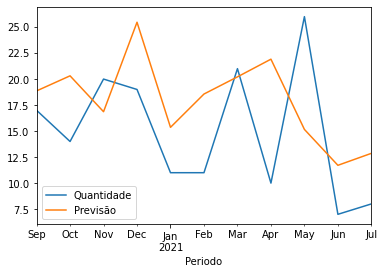

In [19]:
# Unindo os dados real x projetado
Juntando_Bases = pd.concat([Dados_Teste, Base_Previsao], axis=1 )

# Plotando o gráfico
Juntando_Bases.plot();

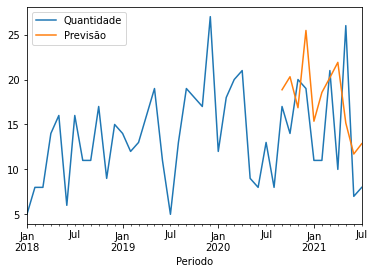

In [20]:
# Unindo os dados real x projetado
Juntando_Bases_02 = pd.concat([Base_Feminicídio['Quantidade'], Base_Previsao], axis=1 )

# Plotando o gráfico
Juntando_Bases_02.plot();

In [21]:
# Função para calcular o erro médio quadratico
from sklearn.metrics import mean_squared_error

# Calculando o erro médio do modelo
mean_squared_error(Dados_Teste, Previsao)

43.359828130831175

In [22]:
# --- Prevendo os próximos meses

# Treinando o Modelo com os dados de treino
Funcao_Auto_Arima.fit( Base_Feminicídio['Quantidade'] )

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [23]:
# Fazendo a previsão até o final do Ano
Previsao_Final_Ano = Funcao_Auto_Arima.predict( n_periods=6 )

In [24]:
# Lista para receeber as datas Futuas
Lista_Datas_Futuras = []

# Loop para gerar as datas
for Loop in range(7,13):
  # Somando as datas
  Proxima_Data = Registro_Inicial + relativedelta(month=Loop)

  # Salvando na Lista
  Lista_Datas_Futuras.append( Proxima_Data )

In [25]:
# Incluindo os dados de previsão em um data frame
Base_Futura = pd.DataFrame( Previsao_Final_Ano, index=Lista_Datas_Futuras, columns=['Futuro'])

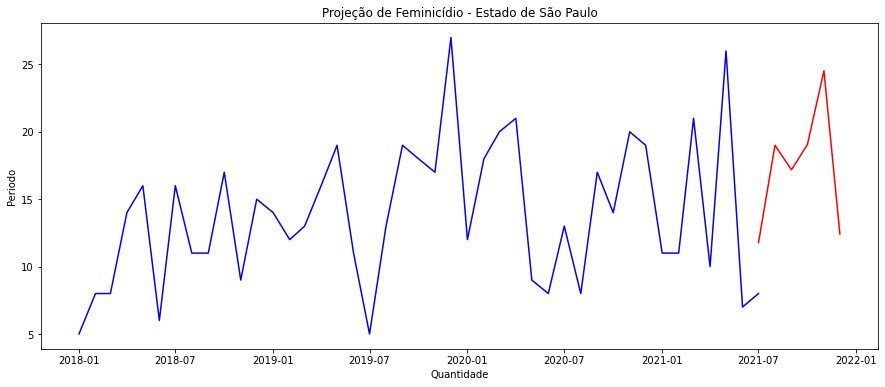

In [26]:
# Plotar o historio com o realizado
plt.figure( figsize=(15,6) )
plt.title('Projeção de Feminicídio - Estado de São Paulo')
plt.xlabel('Quantidade')
plt.ylabel('Periodo')
plt.plot( Base_Feminicídio['Quantidade'], color='blue' )
plt.plot( Base_Futura, color='red' );